In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# ===== Recreate ResNet18 architecture =====
model = models.resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: cat and dog

# ===== Load saved weights =====
if os.path.exists("best_resnet18_catdog.pth"):
    model.load_state_dict(torch.load("best_resnet18_catdog.pth", map_location=torch.device('cpu')))
    model.eval()
    print("✅ Loaded saved ResNet18 model from best_resnet18_catdog.pth")
else:
    print("⚠️ No saved model found. Please run training first.")

# ===== Transformations (resize for ResNet input) =====
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # match training size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


✅ Loaded saved ResNet18 model from best_resnet18_catdog.pth


In [2]:
# Dataset path
base_path = r"C:\Users\JOMARI CASTILLO\Downloads\ML-Sample Exercise\PetImages"

# Data augmentation + normalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Custom dataset loader to skip unwanted folders
class CleanImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [d.name for d in os.scandir(directory) 
                   if d.is_dir() and d.name not in [".ipynb_checkpoints", "test"]]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

# Load dataset (only Cat and Dog)
full_dataset = CleanImageFolder(
    root=base_path,
    transform=transform,
    is_valid_file=lambda path: path.lower().endswith(('.png', '.jpg', '.jpeg'))
)

print("Classes found:", full_dataset.classes)  # Should be ['Cat', 'Dog']

# ===== Limit dataset to 1000 per class =====
targets = full_dataset.targets
indices = []
class_counts = {0: 0, 1: 0}  # 0=Cat, 1=Dog

for i, label in enumerate(targets):
    if class_counts[label] < 1000:
        indices.append(i)
        class_counts[label] += 1

limited_dataset = Subset(full_dataset, indices)

# Split 80/20 into train and validation
train_size = int(0.8 * len(limited_dataset))
val_size = len(limited_dataset) - train_size
train_dataset, val_dataset = random_split(limited_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")


NameError: name 'datasets' is not defined

In [3]:
num_epochs = 15
best_val_acc = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, running_corrects = 0.0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # Validation
    model.eval()
    val_running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_acc = val_running_corrects.double() / len(val_dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {epoch_loss:.4f} - "
          f"Train Acc: {epoch_acc:.4f} - "
          f"Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()


Epoch 1/15 - Train Loss: 0.4392 - Train Acc: 0.7762 - Val Acc: 0.8675
Epoch 2/15 - Train Loss: 0.3303 - Train Acc: 0.8425 - Val Acc: 0.8875
Epoch 3/15 - Train Loss: 0.2883 - Train Acc: 0.8688 - Val Acc: 0.8825
Epoch 4/15 - Train Loss: 0.2757 - Train Acc: 0.8700 - Val Acc: 0.8950
Epoch 5/15 - Train Loss: 0.2638 - Train Acc: 0.8831 - Val Acc: 0.9100
Epoch 6/15 - Train Loss: 0.2791 - Train Acc: 0.8762 - Val Acc: 0.8950
Epoch 7/15 - Train Loss: 0.2875 - Train Acc: 0.8738 - Val Acc: 0.8900
Epoch 8/15 - Train Loss: 0.2716 - Train Acc: 0.8831 - Val Acc: 0.8950
Epoch 9/15 - Train Loss: 0.2881 - Train Acc: 0.8712 - Val Acc: 0.8975
Epoch 10/15 - Train Loss: 0.2452 - Train Acc: 0.8856 - Val Acc: 0.9100
Epoch 11/15 - Train Loss: 0.2332 - Train Acc: 0.8962 - Val Acc: 0.9150
Epoch 12/15 - Train Loss: 0.2733 - Train Acc: 0.8850 - Val Acc: 0.9075
Epoch 13/15 - Train Loss: 0.2552 - Train Acc: 0.8825 - Val Acc: 0.9125
Epoch 14/15 - Train Loss: 0.2560 - Train Acc: 0.8850 - Val Acc: 0.9050
Epoch 15/15 - T

In [4]:
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n🏆 Best model restored with Val Acc: {best_val_acc:.2f}%")
else:
    print("\n⚠️ No best model state was saved.")



🏆 Best model restored with Val Acc: 0.93%


In [7]:
# Save best model after restoring it
torch.save(model.state_dict(), "best_resnet18_catdog.pth")
print("✅ Best model saved as best_resnet18_catdog.pth")


✅ Best model saved as best_resnet18_catdog.pth


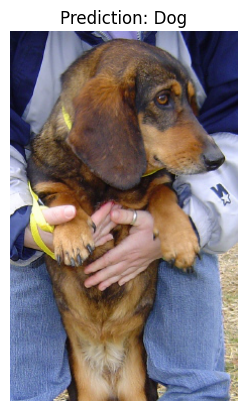

222.jpg → Dog (probs=[0.0122024  0.98779756])


'Dog'

In [11]:
import matplotlib.pyplot as plt
from PIL import Image

# Deterministic transform for inference (no random flips/rotations)
inference_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # match the training size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ✅ Correct label mapping (from your dataset: ['Cat', 'Dog'])
idx_to_class = {0: "Cat", 1: "Dog"}

# Function to predict and display an image
def predict_image(image_path):
    try:
        # Open & force 3-channel RGB
        with Image.open(image_path) as img:
            img = img.convert("RGB")
            display_img = img.copy()
            x = inference_transform(img).unsqueeze(0)

        model.eval()
        with torch.no_grad():
            device = next(model.parameters()).device
            x = x.to(device)
            output = model(x)               # shape [1, 2]
            probs = torch.softmax(output, dim=1)  # convert to probabilities
            pred_class = torch.argmax(probs, dim=1).item()
            prediction = idx_to_class[pred_class]

        # Show image + result
        plt.imshow(display_img)
        plt.axis('off')
        plt.title(f"Prediction: {prediction}")
        plt.show()

        print(f"{os.path.basename(image_path)} → {prediction} (probs={probs.cpu().numpy()[0]})")
        return prediction

    except Exception as e:
        print(f"Skipping {os.path.basename(image_path)} — {type(e).__name__}: {e}")
        return None


# Example usage
image_path = r"C:\Users\JOMARI CASTILLO\Downloads\ML-Sample Exercise\PetImages\Dog\222.jpg"
predict_image(image_path)


In [4]:
import matplotlib.pyplot as plt
from PIL import Image

# Deterministic preprocessing (no random flips for testing)
inference_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

idx_to_class = {0: "Cat", 1: "Dog"}  # match your dataset

def predict_image(image_path, show=True):
    image = Image.open(image_path).convert("RGB")
    img_t = inference_transform(image).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        device = next(model.parameters()).device
        img_t = img_t.to(device)
        outputs = model(img_t)
        probs = torch.softmax(outputs, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

    prediction = idx_to_class[pred_class]

    if show:
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Prediction: {prediction}")
        plt.show()

    print(f"{os.path.basename(image_path)} → {prediction} (probs={probs.cpu().numpy()[0]})")
    return prediction


In [5]:
# Loop through all images in a folder and run predictions
def predict_images_in_folder(folder_path):
    # Get all image file paths in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # case-insensitive check
            image_path = os.path.join(folder_path, filename)
            print(f"\n🔍 Predicting for {filename}...")
            predict_image(image_path)


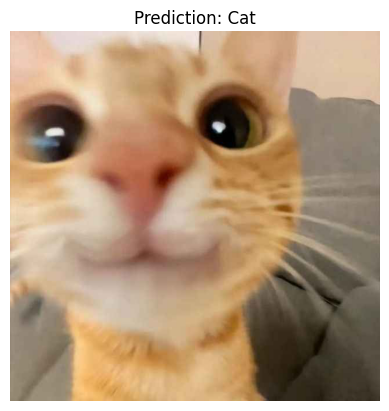

2.jpg → Cat (probs=[0.992815   0.00718495])


'Cat'

In [8]:
# Example: single image
image_path = r"C:\Users\JOMARI CASTILLO\Downloads\ML-Sample Exercise\PetImages\test\2.jpg"
predict_image(image_path)


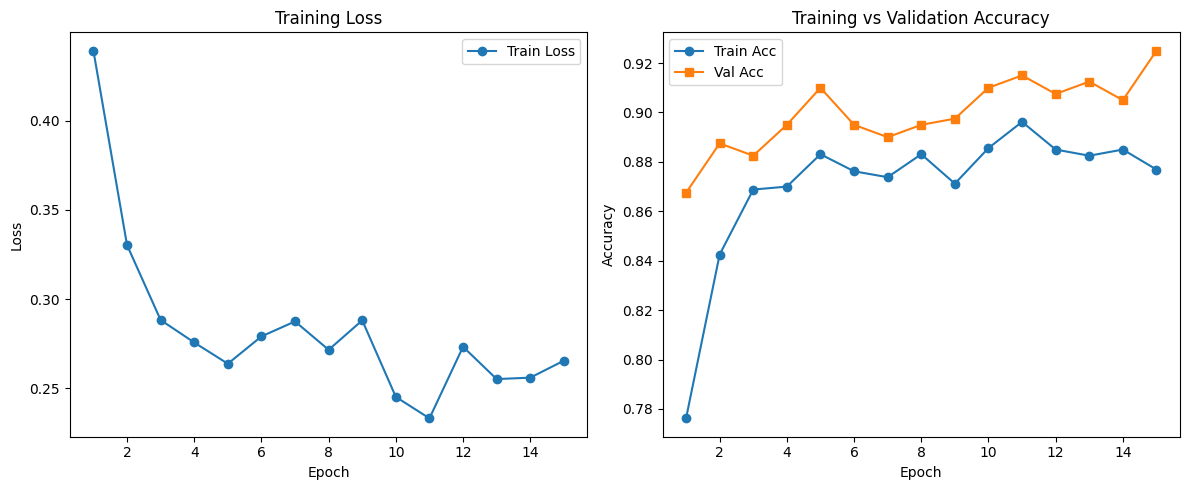

In [21]:
import re
import matplotlib.pyplot as plt

logs = """
Epoch 1/15 - Train Loss: 0.4392 - Train Acc: 0.7762 - Val Acc: 0.8675
Epoch 2/15 - Train Loss: 0.3303 - Train Acc: 0.8425 - Val Acc: 0.8875
Epoch 3/15 - Train Loss: 0.2883 - Train Acc: 0.8688 - Val Acc: 0.8825
Epoch 4/15 - Train Loss: 0.2757 - Train Acc: 0.8700 - Val Acc: 0.8950
Epoch 5/15 - Train Loss: 0.2638 - Train Acc: 0.8831 - Val Acc: 0.9100
Epoch 6/15 - Train Loss: 0.2791 - Train Acc: 0.8762 - Val Acc: 0.8950
Epoch 7/15 - Train Loss: 0.2875 - Train Acc: 0.8738 - Val Acc: 0.8900
Epoch 8/15 - Train Loss: 0.2716 - Train Acc: 0.8831 - Val Acc: 0.8950
Epoch 9/15 - Train Loss: 0.2881 - Train Acc: 0.8712 - Val Acc: 0.8975
Epoch 10/15 - Train Loss: 0.2452 - Train Acc: 0.8856 - Val Acc: 0.9100
Epoch 11/15 - Train Loss: 0.2332 - Train Acc: 0.8962 - Val Acc: 0.9150
Epoch 12/15 - Train Loss: 0.2733 - Train Acc: 0.8850 - Val Acc: 0.9075
Epoch 13/15 - Train Loss: 0.2552 - Train Acc: 0.8825 - Val Acc: 0.9125
Epoch 14/15 - Train Loss: 0.2560 - Train Acc: 0.8850 - Val Acc: 0.9050
Epoch 15/15 - Train Loss: 0.2655 - Train Acc: 0.8769 - Val Acc: 0.9250
"""

# Regex parser
pattern = r"Epoch (\d+)/\d+ - Train Loss: ([0-9.]+) - Train Acc: ([0-9.]+) - Val Acc: ([0-9.]+)"

epochs, train_losses, train_accs, val_accs = [], [], [], []

for match in re.finditer(pattern, logs):
    epoch, t_loss, t_acc, v_acc = match.groups()
    epochs.append(int(epoch))
    train_losses.append(float(t_loss))
    train_accs.append(float(t_acc))
    val_accs.append(float(v_acc))

# --- Plot Loss ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, marker='o', label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# --- Plot Accuracy ---
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, marker='o', label="Train Acc")
plt.plot(epochs, val_accs, marker='s', label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


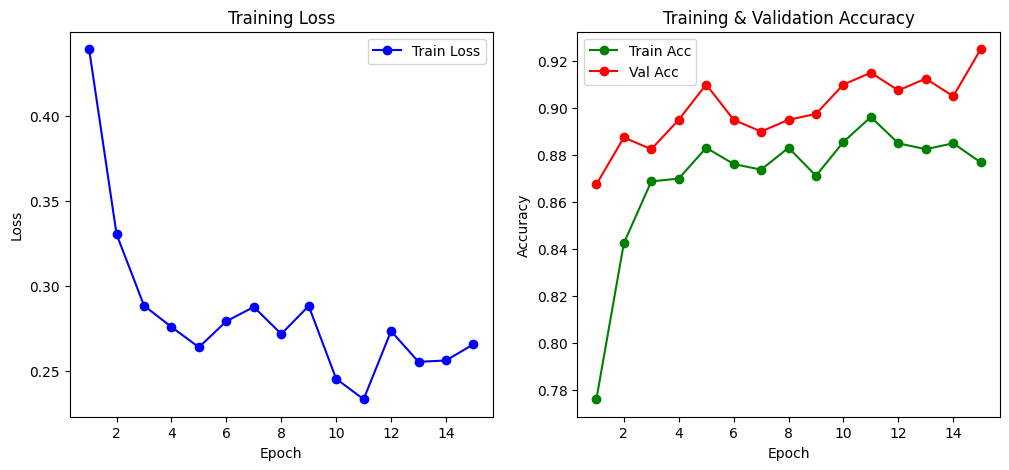

In [22]:
# Cell X: Recreate training history manually
train_losses = [
    0.4392, 0.3303, 0.2883, 0.2757, 0.2638,
    0.2791, 0.2875, 0.2716, 0.2881, 0.2452,
    0.2332, 0.2733, 0.2552, 0.2560, 0.2655
]

train_accuracies = [
    0.7762, 0.8425, 0.8688, 0.8700, 0.8831,
    0.8762, 0.8738, 0.8831, 0.8712, 0.8856,
    0.8962, 0.8850, 0.8825, 0.8850, 0.8769
]

val_accuracies = [
    0.8675, 0.8875, 0.8825, 0.8950, 0.9100,
    0.8950, 0.8900, 0.8950, 0.8975, 0.9100,
    0.9150, 0.9075, 0.9125, 0.9050, 0.9250
]

epochs = range(1, len(train_losses) + 1)

# Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, 'g-o', label='Train Acc')
plt.plot(epochs, val_accuracies, 'r-o', label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()
